# __Generating City Views from Geographic Coordinates__  
EECS 504 Final Project

# Initialization

Comment/Uncomment as needed.

In [ ]:
!pip install mapillary
import mapillary.interface as mly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.8 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
     |████████████████████████████████| 245 kB 63.0 MB/s 
     |████████████████████████████████| 2.2 MB 59.7 MB/s 
     |████████████████████████████████| 75 kB 5.2 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 1.0 MB 68.8 MB/s 
     |████████████████████████████████| 296 kB 78.6 MB/s 
     |████████████████████████████████| 67 kB 7.9 MB/s 
     |████████████████████████████████| 178 kB 81.3 MB/s 
     |████████████████████████████████| 97 kB 2.5 MB/s 
     |████████████████████████████████| 138 kB 74.9 MB/s 
     |████████████████████████████████| 283 kB 78.0 MB/s 
     |████████████████████████████████| 97 kB 7.7 MB/s 
     |████████████████████████████████| 15.7 MB 46.3 MB/s 
     |████████████████████████████████| 61 k

In [4]:
# import pickle
import numpy as np
import matplotlib.pyplot as plt
import os, copy
from google.colab import drive
import cv2

# import time
# import itertools
from matplotlib import image
import glob as glob
from PIL import Image
import random
import geopy.distance

!pip install imagehash
import imagehash

import requests
import json

import time

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

from tqdm import tqdm

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 296 kB 10.0 MB/s 
PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116
Using the GPU!


In [6]:
#hyper parameters

GENERATE_DATASET_FLAG= False #set to true when you want to generate dataset
CLEAN_DATASET= False #set to true when you want to remove duplicates from dataset
IMAGE_SIZE=256
BATCH_SIZE=32
dataset_type = 0 #[0 = 10k images of all cities , 1 = 10k images of one city - Detroit, 2 = 85k images of every city]
train_data_size = 2000

drive.mount('/content/drive')
project_directory="drive/Shareddrives/EECS 504 Project"


dataset_directory=""
if dataset_type==0:
  dataset_directory+='Street View Dataset'
elif dataset_type==1:
  dataset_directory+='Single City Dataset - Detroit'
elif dataset_type==2:
  dataset_directory+='Street View Dataset - 85k'
else:
  print("dataset type not supported")
  GENERATE_DATASET_FLAG=False

zip_directory= project_directory+"/"+dataset_directory
!unzip "$zip_directory" -d "/content"
dataset_directory = "./"+dataset_directory

Streaming output truncated to the last 5000 lines.
  inflating: /content/Street View Dataset/Las Vegas/36.216349791511135_-115.21127879619598_171284638250949.jpg  
  inflating: /content/Street View Dataset/Las Vegas/36.21670468409742_-115.21158993244171_226342539299562.jpg  
  inflating: /content/Street View Dataset/Las Vegas/36.21684317832853_-115.2117133140564_152541170173030.jpg  
  inflating: /content/Street View Dataset/Las Vegas/36.21693406503448_-115.21655201911926_1950763765077970.jpg  
  inflating: /content/Street View Dataset/Las Vegas/36.21696868851373_-115.21506071090698_225584562699877.jpg  
  inflating: /content/Street View Dataset/Las Vegas/36.217046591286035_-115.21389663219452_296354002023442.jpg  
  inflating: /content/Street View Dataset/Las Vegas/36.21705957507386_-115.20741105079651_222016822691245.jpg  
  inflating: /content/Street View Dataset/Las Vegas/36.21707688678765_-115.2165949344635_288617496307939.jpg  
  inflating: /content/Street View Dataset/Las Vegas/

# Generate Dataset

Run the following cells only when the dataset hasn't been created or if it is missing. If the dataset has been generated, dataloader should load from save folder

In [ ]:
def download_images_from_geoJson(coord_dictionary,image_folder,access_token,image_count,img_size=(256,256)):
  """
  Downloads a set of images from mapillary api based on geocoordinates JSON (as defined by mapillary api guide: https://github.com/mapillary/mapillary-python-sdk)

  Args:
    coord_dictionary: dictionary object with targets. Needs to be in geoJSON format:
      {
        features:[{
          geometry:{
            coordinates: [latitude,longitude values]
          },
          properties:{
            id: image_id
          }
        }]
      }
    image_folder: where to save the images
    access_token: mapillary api access token
    image_count: how many images to download
    img_size: output image size

     Images saved in jpg format with filename: "*latitude*_*longitude*_*imageid*.jpg"
  """
  if not os.path.exists(image_folder):
    os.makedirs(image_folder)

  i=0
  fail_count=0
  random.shuffle(coord_dictionary['features']) #shuffle image ids so that the first *image_count* are necessarily near to each other

  for feature in coord_dictionary['features']:
    i+=1
    try:
      
      if feature['properties']['is_pano']:
        i-=1
        continue
      # get lng,lat of each feature
      lng = feature['geometry']['coordinates'][0]
      lat = feature['geometry']['coordinates'][1]
      cord_string = '{}_{}'.format(lat,lng)

      # request the URL of each image
      image_id = feature['properties']['id']
      header = {'Authorization' : 'OAuth {}'.format(access_token)}
      url = 'https://graph.mapillary.com/{}?fields=thumb_2048_url'.format(image_id)
      r = requests.get(url, headers=header)
      data = r.json()
      if 'thumb_2048_url' not in data: 
        i-=1
        continue
    
      image_url = data['thumb_2048_url']

      # save each image with ID as filename to directory by sequence ID
      image_fn='{}/{}_{}.jpg'.format(image_folder,cord_string, image_id)
      with open(image_fn, 'wb') as handler:
          image_data = requests.get(image_url, stream=True).content
          handler.write(image_data)   #save original image
          img = Image.open(image_fn)
          img=img.resize(img_size)
          img.save(image_fn)          #save resized image
          handler.close()
      print("{}/{}".format(i,image_count))
      if i >=image_count: break
    except:
      print("failed to download image")
      fail_count+=1
      i-=1
  print("{} images failed to download out of {}".format(fail_count,image_count))
     

In [ ]:
def generate_coord_dicts_from_list(coordinates_list,access_token):
  """
  Generates a list of geocoordinate dictionary objects given a list of target coordinates and radii

  Args:
    coordinates_list: list of coordinate dictionaries with latitude, longitude, raddi, and name in format: 
      {
        "latitude": float
        "longitude": float
        "radius": int
        "name": string
      }
    access_token: mapillary access token

  Returns: 
    dict_list: list of dictionaries with contents:
      {
        "name": string
        "images": {
          "type": string
          "features": list of images features
          }
      }
  """

  dict_list = []
  #print(coordinates_list)
  for coords in coordinates_list:
    try:
      lat=coords["latitude"]
      lon=coords["longitude"]
      rad=coords["radius"]
      name=coords["name"]

      mly.set_access_token(access_token)
      print("getting images for {}".format(name))
      images =mly.get_image_close_to(latitude=lat,longitude=lon,radius=rad)
      if images is None:
        continue
      else:
        images=images.to_dict()

      dict={
          "name":name,
          "images": images
      }
      dict_list.append(dict)
      print("done\n")
    except:
      print("Failed to download for city {}".format(coords["name"]) )
      continue
    
  return dict_list



In [ ]:
def get_images_by_city(coords,folder,token,total_images=10000,img_size=(256,256)):
  """
  Downloads images using mapillary api given list of target coordinates for cities and list of radii for those targets

  Args: 
    coords: list of dictionaries which contain set of images for a city. format contents:
      {
        "name": string
        "type": string
        "features": list of images features
      }
    folder: folder name to save images and coordinates (images are named by their coordinates)
    total_images: how big should the dataset be?
    img_size: images are square with shape (img_size x img_size)
  """

  for city in coords:
    city_folder = "{}/{}".format(folder,city["name"])
    if  os.path.exists(city_folder):
      print("City folder already found, skipping...")
      continue
    print("downloading images for {}".format(city['name']))
    download_images_from_geoJson(city["images"],city_folder,access_token=token,image_count=total_images//len(coords),img_size=img_size)

In [ ]:
def get_images_of_city(coords,folder,token,city_name,total_images=10000,img_size=(256,256)):
  """
  Downloads images using mapillary api given list of target coordinates for a singal city and radii

  Args: 
    coords: list of dictionaries which contain set of images for a city. format contents:
      {
        "name": string
        "type": string
        "features": list of images features
      }
    folder: folder name to save images and coordinates (images are named by their coordinates)
    total_images: how big should the dataset be?
    img_size: images are square with shape (img_size x img_size)
  """
  city = next(item for item in coords if item["name"] == city_name)
  print("downloading images for {}".format(city["name"]))
  max_images = len(city['images']['features'])
  if max_images<total_images:
    print("{} images not available, downloading {} images".format(total_images,max_images))
    total_images=max_images
  download_images_from_geoJson(city["images"],folder,access_token=token,image_count=total_images,img_size=img_size)

In [ ]:
if(GENERATE_DATASET_FLAG):
  

  token = 'MLY|5251016941670656|82a75da66cb517858d6c3428f3e5a963' #my personal token for mapillary


  json_f=open("{}/City coordinates JSON/populated_places_simplified.json".format(project_directory))
  coordinate_list = json.load(json_f)
  print("Downloading images...")
  if not os.path.exists("{}/City coordinates JSON/city_feature_list.json".format(project_directory)):
    print("Did not find existing list, creating new list")
    city_coord_lists = generate_coord_dicts_from_list(coordinate_list['features'],token)
    with open("{}/City coordinates JSON/city_feature_list.json".format(project_directory), mode="w") as f:
      json.dump(city_coord_lists, f)
  else:
    print("Found existing list.")
    file = open("{}/City coordinates JSON/city_feature_list.json".format(project_directory))
    city_coord_lists=json.load(file)
    file.close()

  if dataset_type==0:
    get_images_by_city(city_coord_lists,dataset_directory,token,img_size=(IMAGE_SIZE,IMAGE_SIZE))
  elif dataset_type== 1:
    get_images_of_city(city_coord_lists,dataset_directory,token,city_name='Detroit',img_size=(IMAGE_SIZE,IMAGE_SIZE))
  elif dataset_type== 2:
    get_images_by_city(city_coord_lists,dataset_directory,token,total_images = 100000,img_size=(IMAGE_SIZE,IMAGE_SIZE))
  else:
    print("dataset type not supported")


In [ ]:
# Inspired from https://github.com/JohannesBuchner/imagehash repository
def visualize_data(dataset_path,num_samples=5):
  image_paths=[]
  if dataset_type ==1:
      image_paths.append(glob.glob(dataset_path+"/*"))
  else:
    for city_folder in glob.glob(dataset_path+"/*"):
      image_paths.append(glob.glob(city_folder+"/*"))
  image_paths = [item for sublist in image_paths for item in sublist]
  random.shuffle(image_paths)
  print("Found {} images".format(len(image_paths)))

  images=[]
  city=[]
  for img_path in image_paths[:num_samples]:
    print(img_path)
    img=Image.open(img_path)
    images.append(np.asarray(img,dtype=np.float64))
    city.append(img_path.split('/')[-2])
  figure, ax = plt.subplots(nrows=num_samples//5,ncols=5,figsize=(15,8))
  for i in range(5*(num_samples//5)):
    ax.ravel()[i].imshow(np.uint8(images[i]))
    ax.ravel()[i].set_axis_off()
    ax.ravel()[i].set_title(city[i])
  plt.tight_layout(pad=1)
  plt.show()


In [ ]:
def alpharemover(image):
    if image.mode != 'RGBA':
        return image
    canvas = Image.new('RGBA', image.size, (255,255,255,255))
    canvas.paste(image, mask=image)
    return canvas.convert('RGB')

def with_ztransform_preprocess(hashfunc, hash_size=8):
    def function(path):
        image = alpharemover(Image.open(path))
        image = image.convert("L").resize((hash_size, hash_size), Image.ANTIALIAS)
        data = image.getdata()
        quantiles = np.arange(100)
        quantiles_values = np.percentile(data, quantiles)
        zdata = (np.interp(data, quantiles_values, quantiles) / 100 * 255).astype(np.uint8)
        image.putdata(zdata)
        return hashfunc(image)
    return function
  
dhash_z_transformed = with_ztransform_preprocess(imagehash.dhash, hash_size = 8)

In [ ]:

if CLEAN_DATASET:
  for city_folder in glob.glob(dataset_directory+"/*"):
  # city_folder=dataset_directory #uncomment for single city dataset
      image_paths=[]
      print("working on :: {}".format(city_folder))
      for city_folder in glob.glob(city_folder+"/*"): #comment out for loop for single city dataset
          image_paths.append(city_folder)

      hash_list=[]
      for path in image_paths:
          try:
              hash=dhash_z_transformed(path) 
          except:
              print("bad image")
              os.remove(path)
              continue     
          # print("{} :: {}".format(path,dhash_z_transformed(path)))
          if hash in hash_list:
              print("this is a duplicate :: {}".format(path))
              os.remove(path)
          else:
              hash_list.append(hash)
          


Found 9480 images
./Street View Dataset/Izmir/38.43394663714196_27.140843868255615_924319908358106.jpg
./Street View Dataset/Zurich/47.37103580551377_8.558633923530579_1200178540412344.jpg
./Street View Dataset/Amman/31.949617826881735_35.932422280311584_181890130513008.jpg
./Street View Dataset/Mumbai/19.001065792823496_72.84650087356567_282686216975579.jpg
./Street View Dataset/Ufa/54.791991838497154_56.0370272397995_166633788893078.jpg


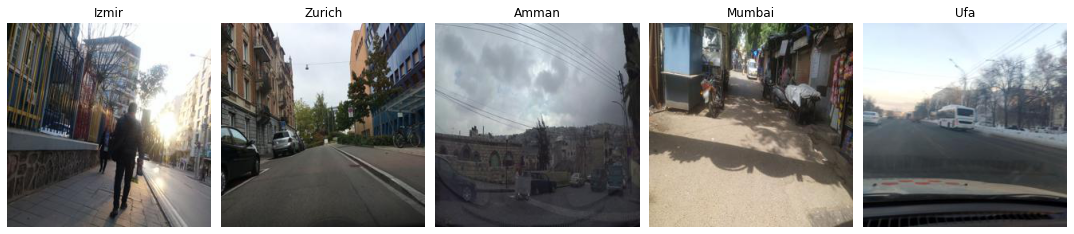

In [ ]:
visualize_data(dataset_directory)

# Build Dataloaders for GAN
Optional split for training and testing GAN

In [7]:
class Coords2Images(Dataset): #can rename class if needed
  def __init__(self, root_dir, split='train', transform=None):
    """
    Args:
        root_dir: the directory of the dataset
        transform: pytorch transformations.
    """
    image_paths=[]
    if dataset_type==1:
      for img_path in glob.glob(root_dir+"/*"):
        image_paths.append(img_path)
    else:
      for city_folder in glob.glob(root_dir+"/*"):
        image_paths.append(glob.glob(city_folder+"/*"))
      image_paths = [item for sublist in image_paths for item in sublist]

    random.shuffle(image_paths)

    if split=='train':
      image_paths = image_paths[0 : train_data_size]
    
    elif split=='test':
      image_paths = image_paths[train_data_size : len(image_paths)]

    self.files=image_paths
    self.transform = transform
    


  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):

      # example file path: drive/Shareddrives/EECS 504 Project/Street View Dataset/Madurai/9.920836585337867_78.11832904815674_852247692310906.jpg
      img=cv2.imread(self.files[idx])
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      


      lat = self.files[idx].split('_')[0].split('/')[-1]
      lon = self.files[idx].split('_')[1]

      coords=torch.tensor([float(lat),float(lon)]).to(device)

      if self.transform:
          img = self.transform(img)
      return img , coords


################################# INITIALIZE GAN DATALOADER ###################
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE))
])

dataset=Coords2Images(root_dir = dataset_directory , transform = transform)

dataset_loader = DataLoader(dataset,batch_size=BATCH_SIZE ,shuffle = False)

# Check number of images
print('Number of images {}'.format(len(dataset)))

Number of images 2000


torch.Size([32, 3, 256, 256])
torch.Size([32, 2])


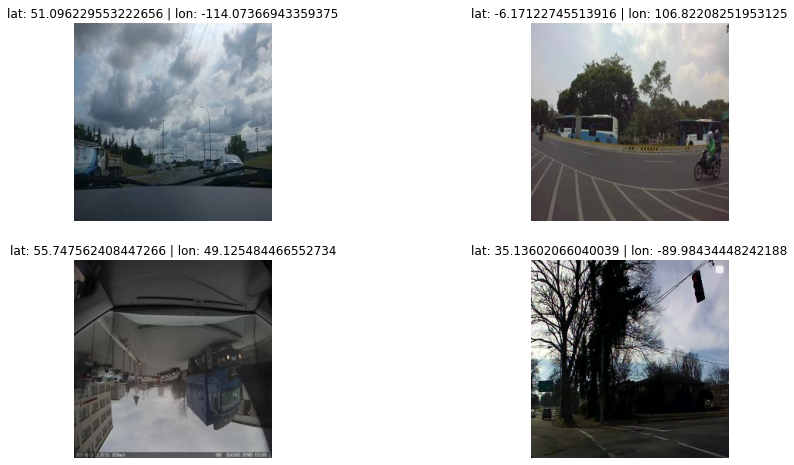

In [8]:
# #Sample Output used for visualization
test,coords = dataset_loader.__iter__().__next__()
print(test.size())
print(coords.size())

# plot sample image
fig, axes = plt.subplots(2, 2,figsize=(15,8))
axes = np.reshape(axes, (4, ))
for i in range(4):
  example = test[i].numpy().transpose((1, 2, 0))
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  example = std * example + mean
  axes[i].set_title("lat: {} | lon: {}".format(coords[i][0],coords[i][1]))
  axes[i].imshow(example)
  axes[i].axis('off')
plt.legend(coords[:4])
plt.show()

#Build Gan Architectures

In [9]:
#Build Generator Architecture:
#Sample noise prior dimensions R^z N(0,1)
#fully-connected layer to a small dimension 128
#leaky-Relu

class generator(nn.Module):
  def __init__(self):
    super(generator,self).__init__()

    self.noise_dim = 100 # noise
    self.coordinates_dim = 2 # coordinates
    self.latent_dim = self.noise_dim + self.coordinates_dim
    self.ngf = 64 # Variable controlling Generator's feature map size
    
    # based on: https://github.com/aelnouby/Text-to-Image-Synthesis/blob/master/models/gan_cls.py
    K = 4 # kernel_size
    S = 2 # stride
    P = 1 # padding_size

    self.netG = nn.Sequential(
        # Layer
        nn.ConvTranspose2d(self.latent_dim, self.ngf*32, K, 1, 0, bias=False), # stride and padding size are adjusted.
        nn.BatchNorm2d(self.ngf*32),
        nn.LeakyReLU(), # if working improperly, replace this with nn.ReLU()
        
        # Layer
        nn.ConvTranspose2d(self.ngf*32, self.ngf*16, K, S, P, bias=False), # stride and padding size are adjusted.
        nn.BatchNorm2d(self.ngf*16),
        nn.LeakyReLU(), # if working improperly, replace this with nn.ReLU()

        # Layer
        nn.ConvTranspose2d(self.ngf*16, self.ngf*8, K, S, P, bias=False), # stride and padding size are adjusted.
        nn.BatchNorm2d(self.ngf*8),
        nn.LeakyReLU(), # if working improperly, replace this with nn.ReLU()

        # Layer
        nn.ConvTranspose2d(self.ngf*8, self.ngf*4, K, S, P, bias=False),
        nn.BatchNorm2d(self.ngf*4),
        nn.LeakyReLU(), # if working improperly, replace this with nn.ReLU()

        # Layer
        nn.ConvTranspose2d(self.ngf*4, self.ngf*2, K, S, P, bias=False),
        nn.BatchNorm2d(self.ngf*2),
        nn.LeakyReLU(), # if working improperly, replace this with nn.ReLU()
        
        # Layer
        nn.ConvTranspose2d(self.ngf*2, self.ngf, K, S, P, bias=False),
        nn.BatchNorm2d(self.ngf),
        nn.LeakyReLU(), # if working improperly, replace this with nn.ReLU()

        # Layer
        nn.ConvTranspose2d(self.ngf, 3, K, S, P, bias=False),
        nn.Tanh()
        # Final size is (3 X image_size X image_size)
    )

  def normalize_coordinates(self, coordinates):
    """
    Normalize coordinates.
    Args:
      coordinates: a tuple (latitude, longitude)
      latitude and longitude are in range of [-90, 90] and [-180, 180], respectively.
    Return:
      (normalzied latitude, normalized longitude)
    """
    
    # x, y = coordinates.clone()
    x, y = coordinates[:, 0].clone(), coordinates[:, 1].clone()
    x += 90
    y += 180
    x /= 180
    y /= 360
    # x = x.unsqueeze(0)
    # y = y.unsqueeze(0)
    return x, y
  
  def forward(self, x, coordinates):
    l1, l2 = self.normalize_coordinates(coordinates) # latitude, longitude
    coordinates_vector = torch.stack([l1, l2], dim=1) #.to(device)
    # coordinates_vector = torch.cat([l1, l2], dim=0).unsqueeze(0) #.to(device)
    # x = x.unsqueeze(0)
    # print(x.shape, coordinates_vector.shape)
    latent_vector = torch.cat([coordinates_vector, x], dim=1).unsqueeze(2).unsqueeze(3)#.to(device)
    # print(latent_vector.shape)
    return self.netG(latent_vector)

In [10]:
# print(test.size())
# print(coords.size())
noise_vector_size = 100
x = torch.rand((coords.shape[0], noise_vector_size)).to(device)
G = generator().to(device)
G_result = G(x, coords)
print(G_result.shape)

torch.Size([32, 3, 256, 256])


In [11]:
#Build Discriminator Architecture
#several layers of stride-2 convolution
#spatial batch normalization
#leaky ReLU
#Refer to this paper:
#Batch Normalization: Accelerating Deep Network Training by
#Reducing Internal Covariate Shift

class discriminator(nn.Module):
  def __init__(self):
    super(discriminator, self).__init__()
    #self.convolutions...
    self.ndf = 64
    self.coordinates_dim = 2

    K, S, P = 4, 2, 1 # kernel_size, stride, padding_size
    self.netD_front = nn.Sequential(
        nn.Conv2d(3, self.ndf, K, S, P, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(self.ndf, self.ndf*2, K, S, P, bias=False),
        nn.BatchNorm2d(self.ndf*2),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(self.ndf*2, self.ndf*4, K, S, P, bias=False),
        nn.BatchNorm2d(self.ndf*4),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(self.ndf*4, self.ndf*8, K, S, P, bias=False),
        nn.BatchNorm2d(self.ndf*8),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(self.ndf*8, self.ndf*16, K, S, P, bias=False),
        nn.BatchNorm2d(self.ndf*16),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(self.ndf*16, self.ndf*32, K, S, P, bias=False),
        nn.BatchNorm2d(self.ndf*32),
        nn.LeakyReLU(0.2, inplace=True)
    )

    self.netD_back = nn.Sequential(
        nn.Conv2d(self.ndf*32+self.coordinates_dim, 1, K, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def normalize_coordinates(self,coordinates):
    """
    Normalize coordinates.
    Args:
      coordinates: a tuple (latitude, longitude)
      latitude and longitude are in range of [-90, 90].
      lat -90 90
      long -180 180
    Return:
      (normalzied latitude, normalized longitude)
    """
    # x, y = coordinates.clone()
    x, y = coordinates[:, 0].clone(), coordinates[:, 1].clone()
    x += 90
    y += 180
    x /= 180
    y /= 360
    # x = x.unsqueeze(0)
    # y = y.unsqueeze(0)
    return x, y

  def forward(self, x, coordinates):
    # x_intermediate = self.netD_front(x.unsqueeze(2).unsqueeze(3))
    x_intermediate = self.netD_front(x)
    l1, l2 = self.normalize_coordinates(coordinates) # latitude, longitude
    coordinates_vector = torch.stack([l1, l2], dim=1)# .unsqueeze(2).unsqueeze(3)
    coordinates_vector = coordinates_vector.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)
    x_project = torch.cat([coordinates_vector, x_intermediate], 1)
    output = self.netD_back(x_project)
    return output.view(-1,1).squeeze(1), x_intermediate

# Update!

In [12]:
# print(test.size())
# print(coords.size())
# noise_vector_size = 100
# x = torch.rand((coords.shape[0], noise_vector_size)).to(device)
D = discriminator().to(device)
D_result = D(G_result, coords)
print(D_result[0])#.shape)

tensor([0.5497, 0.3627, 0.4871, 0.5660, 0.3932, 0.5281, 0.5515, 0.4652, 0.6229,
        0.3933, 0.5038, 0.5473, 0.5809, 0.3836, 0.5516, 0.5134, 0.4477, 0.5314,
        0.5143, 0.5593, 0.5256, 0.4922, 0.5608, 0.4655, 0.4690, 0.4671, 0.3373,
        0.4351, 0.5297, 0.5769, 0.4268, 0.5157], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


#Train GAN Function

In [ ]:
"""
*debug* Show test GAN image’s result function		
Train GAN function
*debug* param count function and show results function
Training function (will need loss functions, gradient step, and *debug* loss progress)
Execute train function (*debug* need flag for how much of the dataset to use -> 1k for debugging, 10k+ for real training)
*debug* Use “Show test GAN image’s result function” for every x epochs
Save weight function
Load weights function
"""

'\n*debug* Show test GAN image’s result function\t\t\nTrain GAN function\n*debug* param count function and show results function\nTraining function (will need loss functions, gradient step, and *debug* loss progress)\nExecute train function (*debug* need flag for how much of the dataset to use -> 1k for debugging, 10k+ for real training)\n*debug* Use “Show test GAN image’s result function” for every x epochs\nSave weight function\nLoad weights function\n'

In [13]:
# Helper function for showing result.
def process_image(img):
  return (img.cpu().data.numpy().transpose(1, 2, 0) + 1) / 2

def show_result(G, x_, y_, num_epoch):
  noise = torch.randn(y_.shape[0],100).cuda()
  predict_images = G(noise, y_)

  num_show = 1
  fig, ax = plt.subplots(num_show, 2, figsize=(8,4))
  
  for i in range(num_show):
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    
    ax[0].cla()
    ax[0].imshow(process_image(x_[0]))
    ax[1].cla()
    ax[1].imshow(process_image(predict_images[0]))
    
  
  plt.tight_layout()
  label_epoch = 'Epoch {0}'.format(num_epoch)
  fig.text(0.5, 0, label_epoch, ha='center')
  label_input = 'Real View' + str(y_[0][0]) + str(y_[0][1])
  fig.text(0.25, 1, label_input, ha='center')
  label_truth = 'Generated View'
  fig.text(0.75, 1, label_truth, ha='center')

  plt.show()

# Helper function for counting number of trainable parameters.
def count_params(model):
  '''
  Counts the number of trainable parameters in PyTorch.
  Args:
      model: PyTorch model.
  Returns:
      num_params: int, number of trainable parameters.
  '''
  num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])
  return num_params

In [14]:
# Training function with loss 
# torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
#Building up the code with what we want to be done

#find L appropiate loss functions
#simple square loss used in the style encoder
# S(x) -> s, G(s,phi) -> x

#based off this GitHub code
#https://github.com/aelnouby/Text-to-Image-Synthesis
#training code
#https://github.com/aelnouby/Text-to-Image-Synthesis/blob/master/trainer.py

#Initialize losses
L2_loss = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean') #loss function for the generator as listed in a paper
L1_loss = torch.nn.L1Loss() #as seen in github for Text-to-image synthesis code
criterion = torch.nn.BCELoss() #as seen in github for Text-to-image synthesis code
#This is similar to our criterion for the BCELoss function

#Initialize constants
beta1 = 0.5
iteration = 0
lr = .001
#l1_coef = 
#l2_coef = l2_coef

#loss function for the discriminator
#not creating a class as seen in the github code

def train(G,D, num_epochs):

  hist_D_losses = []
  hist_G_losses = []

  #num_iter = 0

  #optimizer_functions
  optimD = torch.optim.Adam(G.parameters(), lr, betas=(beta1, 0.999))
  optimG = torch.optim.Adam(D.parameters(), lr, betas=(beta1, 0.999))

  start_time = time.time()

  for epoch in range(num_epochs):

    epoch_start_time = time.time()

    for x_,y_ in tqdm(dataset_loader): #can use data_loader to run

      #x_ images shape batch size 3 by 256 by 256
      #y_ label is batch size by 2

      #Grab images
      #so we have two things within

      x_, y_ = x_.cuda(), y_.cuda()

      #fake image equals to generator noise

      #Train the discriminator

      #zero the gradient
      D.zero_grad()

      #noise 100 length, batchsize 100 matrix and image
      noise = torch.randn(BATCH_SIZE, 100).cuda() #batch_size glogbal variable

      if noise.shape[0] != y_.shape[0]:
        noise = torch.randn(y_.shape[0],100).cuda()
      

      #noise = noise.view(noise.size(0), 100, 1, 1) should not be needed in dataloader

      #Pass into generator
      fake_image = G(noise,y_)

      #wrong coordinates, create a random variable plus or

      #if statement to stay within bounds

      #generate fake coordinates

      num_coordinates =y_.shape[0]
      pos_lat = torch.rand(num_coordinates,1)*90
      neg_lat = torch.rand(num_coordinates,1)*(-90)

      latitude = pos_lat + neg_lat

      pos_long = torch.rand(num_coordinates,1)*180
      neg_long = torch.rand(num_coordinates,1)*(-180)

      longitude = pos_long + neg_long

      fake_coordinates = torch.cat((latitude,longitude), dim = 1).cuda()


      #do this whole thing twice, one for the input, one for the output
      #D_input_fake = torch.cat([x_, fake_image], 1) #combining the input fake image and the generated fake image
      D_result_fake, _ = D(fake_image,y_) #batch of coordinates

      #do this whole thing twice, one for the input, one for the output
      #D_input_real = torch.cat([x_, y_], 1) #combining the input fake image and the real image
      D_result_real, _ = D(x_,y_) #.squeeze() #

      D_results_mix,_ = D(x_, fake_coordinates)

      #calculate the outputs here, Question is do we want an additional noise step
      D_train_loss = criterion(D_result_fake, torch.zeros(D_result_fake.size()).cuda()) #.detach().item() #based on zeros for fake
      D_train_loss_real = criterion(D_result_real, torch.ones(D_result_real.size()).cuda()) #.detach().item() #based on ones for real


      D_train_loss_mix = criterion(D_results_mix, torch.zeros(D_result_fake.size()).cuda())
      D_loss =  D_train_loss + D_train_loss_real + D_train_loss_mix 

      hist_D_losses.append(D_loss.detach().item())
      #Steps
      D_loss.backward()
      optimD.step()

      #Training the generator
      G.zero_grad()
      noise = torch.randn(y_.shape[0], 100).cuda() #replace batch_size with y_.shape()

      #concatenation in order to distinguis, input real and fake images
      G_result = G(noise,y_)
      # D_input = torch.cat([x_, G_result], 1)
      D_result,_ = D(G_result, y_) #used to be D(x_,y_s)

      # G_input = torch.cat([y_, ], 1)

      #Generator Loss Function
      G_train_loss = criterion(D_result, torch.ones(D_result.size()).cuda()) + 100 * L1_loss(G_result, x_) #input result, 
      #hist_G_L1_losses.append(L1_loss(G_result, y_).detach().item())
      hist_G_losses.append(G_train_loss.cuda().detach().item())
      
      #g_loss = criterion(outputs, real_labels) \
       # + l2_coef * l2_loss(activation_fake, activation_real.detach()) \
        #+ l1_coef * l1_loss(fake_images, right_images)

      #Ending steps
      G_train_loss.backward()
      optimG.step()

    #printing at the end of each epoch
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - using time: %.2f seconds' % ((epoch + 1), num_epochs, per_epoch_ptime))
    print('loss of discriminator D: %.3f' % (torch.mean(torch.FloatTensor(hist_D_losses))))
    print('loss of generator G: %.3f' % (torch.mean(torch.FloatTensor(hist_G_losses))))
    if epoch == 0 or (epoch + 1) % 1 == 0:
      with torch.no_grad():
        show_result(G, x_, y_, (epoch+1))

  end_time = time.time()
  total_ptime = end_time - start_time


  return hist_D_losses, hist_G_losses

In [15]:
# print out the model summary
G = generator().cuda()
D = discriminator().cuda()
print("G :", G)
print("D :", D)
#summary(G, (3, 256, 256))
#pdb.set_trace()
#summary(D, (3, 256, 256))

G : generator(
  (netG): Sequential(
    (0): ConvTranspose2d(102, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), str

In [16]:
# define weights function
# Define network
#example from course code
G_100 = generator()
D_100 = discriminator()

#G_100.weight_init(mean=0.0, std=0.02)
#D_100.weight_init(mean=0.0, std=0.02)

G_100.cuda()
D_100.cuda()
G_100.train()
D_100.train()


discriminator(
  (netD_front): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps

In [17]:
"""
G: generator network architecture
D: discriminator architecture
num_epochs: integer for number of epochs
only_L1: instance to remedy
"""

#training, you will be expecting 1-2 minutes per epoch.
# TODO: change_num_epochs if you want
hist_D_losses, hist_G_losses = train(G_100, D_100, num_epochs = 10)

Output hidden; open in https://colab.research.google.com to view.

In [20]:
torch.save(G_100.state_dict(), "./G10.pth")
torch.save(D_100.state_dict(), "./D10.pth")

In [19]:
G_100.load_state_dict(torch.load('./G10.pth'))
D_100.load_state_dict(torch.load('./D10.pth'))

<All keys matched successfully>

#CNN Model

In [ ]:
# parameters
batch_size = 32

epochs = 25

input_size = 227

train_normal_data_size = 5000

dataset_type = 2 #[0 = 10k images of all cities , 1 = 10k images of one city - Detroit, 2 = 85k images of every city]
train_data_size = 80000

drive.mount('/content/drive')
project_directory="drive/Shareddrives/EECS 504 Project"


dataset_directory="./"
if dataset_type==0:
  dataset_directory+='Street View Dataset'
elif dataset_type==1:
  dataset_directory+='Single City Dataset - Detroit'
elif dataset_type==2:
  dataset_directory+='Street View Dataset - 85k'
else:
  print("dataset type not supported")
  GENERATE_DATASET_FLAG=False

!unzip dataset_directory -d "/content"

# CNN Dataset and Dataloader

In [ ]:
# Decide if any other transform needed
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((input_size, input_size)),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),])

class GeoTrainDataset(Dataset):
  def __init__(self, image_paths, transform=None):
        super().__init__()

        

        self.files=image_paths
        self.transform = transform

  def __len__(self):
    return len(self.files)


        

  def __getitem__(self, idx):
      file_name = self.files[idx]

      # get lat, lon of each feature
      lat = file_name.split('_')[0].split('\\')[-1]
      lon = file_name.split('_')[1]

      decimal_coords = torch.tensor([float(lat), float(lon)]).to(device)

      with Image.open(file_name) as img:
        img = np.asarray(img)
        img = self.transform(img)

        return img, decimal_coords

# CNN Classifier

In [ ]:
''' 
A simplified Classifier for testing
'''
class GeoCNN(nn.Module):
  # initializers
  def __init__(self):
    super(GeoCNN, self).__init__()
    # encoder
    self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
    self.batch1 = nn.BatchNorm2d(64,eps=1e-05,momentum=0.1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1)
    self.batch2 = nn.BatchNorm2d(64*2,eps=1e-05,momentum=0.1)
    self.relu2 = nn.ReLU()
    self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1)
    self.batch3 = nn.BatchNorm2d(64*4,eps=1e-05,momentum=0.1)
    self.relu3 = nn.ReLU()
    # self.conv4 = nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1)
    # self.batch4 = nn.BatchNorm2d(64*8,eps=1e-05,momentum=0.1)
    # self.relu4 = nn.ReLU()
    self.conv5 = nn.Conv2d(64 * 4, 2, 4, 2, 1)
    self.linear= nn.Linear(64*8,2)
    self.tan=nn.Tanh()
    self.sig =nn.Sigmoid()


  # forward method
  def forward(self, input):
    # pass through encoder
    c1 = self.conv1(input)
    b1 = self.batch1(c1)
    r1 = self.relu1(b1)

    c2 = self.conv2(r1)
    b2 = self.batch2(c2)
    r2 = self.relu2(b2)

    c3 = self.conv3(r2)
    b3 = self.batch3(c3)
    r3 = self.relu3(b3)



    c5 = self.conv5(r3)
    flat = torch.flatten(c5, 1)
    out= self.linear(flat)



    return out

In [ ]:
model = GeoCNN().to(device)
summary(model, (3, 256, 256))

In [ ]:
'''
Full Classifier
'''
class GeoClassifier(nn.Module):
    def __init__(
        self,
    ):
        super().__init__()
        '''
        Args:
        '''
        
        # AlexNet-VGG-16-BN architecture
        self.operation = nn.Sequential(nn.Conv2d(3, 96, 11, 1, 1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(3, 2),
                                       nn.Conv2d(96, 256, 5, 1, 2),
                                       nn.ReLU(),
                                       nn.MaxPool2d(3, 2),
                                       nn.Conv2d(256, 384, 3, 1, 1),
                                       nn.ReLU(),
                                       nn.Conv2d(384, 384, 3, 1, 1),
                                       nn.ReLU(),
                                       nn.Conv2d(384, 256, 3, 1, 1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(3, 2),  # end of AlexNet
                                       nn.Conv2d(256, 256, 3, 1, 1), # start part of VGG-16
                                       nn.BatchNorm2d(256, eps=1e-05, momentum=0.1),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, 1, 1), 
                                       nn.BatchNorm2d(256, eps=1e-05, momentum=0.1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2, 2),
                                       nn.Conv2d(256, 512, 3, 1, 1), 
                                       nn.BatchNorm2d(512, eps=1e-05, momentum=0.1),
                                       nn.ReLU(),
                                       nn.Conv2d(512, 512, 3, 1, 1), 
                                       nn.BatchNorm2d(512, eps=1e-05, momentum=0.1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2, 2))
        
        self.relu = nn.ReLU()
        self.dense = nn.Linear(18432, 4096)
        self.dense1 = nn.Linear(4096, 100)
        self.dense2 = nn.Linear(100, 2)
    def forward(self, x):
        '''
        Args:
            x: Image batch

        Return:
            projected: Coordinate predictions
        '''

        #batches = x.size()[0]
        x = self.operation(x)
        x = torch.flatten(x,1)

        
        x = self.relu(self.dense(x))
        x = self.relu(self.dense1(x))
        out = self.dense2(x)

        return out

In [ ]:
model = GeoClassifier().to(device)
summary(model, (3, 227, 227))

#Train CNN function

In [ ]:
def get_batch_distances(inputs,targets):
    dist_list =[]
    length=inputs.size()[0]
    for i in range(length):
        ins=inputs.detach().cpu().numpy()[i]
        tar=targets.detach().cpu().numpy()[i]
        try:
            dist_list.append(geopy.distance.geodesic(ins,tar).km) #distance between two lat,lon pairs in km
        except:
            dist_list.append(20000) #if coordinates are out of bounds, return maximum error (half earth circumference = 20,000km)
    return torch.tensor(dist_list)
    

In [ ]:
def get_geoguessr_score(input,target):
    a= 5000
    b=0.998
    x=geopy.distance.geodesic(input,target).km
    score = a*b**x
    return score


In [ ]:
def getGeoClassifierPredictions(img, model):
  img = img.to(device)
  outs = model(img)

  return outs

In [ ]:
def train_model(model, dataloaders, save_dir = None, num_epochs=20):
    """
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    """

    val_acc_history = []
    tr_acc_history = []
    optimizer=optim.Adam(model.parameters(),betas=(0.9,0.999),lr=0.001)
    criterion = nn.MSELoss().cuda()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 12000.0
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            distance = 0
            running_hits=0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                optimizer.zero_grad()
                
                outputs=model(inputs)
                #outputs = F.tanh(outputs)
                # outputs[:,0]=outputs[:,0]*180-90
                # outputs[:,1]=outputs[:,1]*360-180
                loss=criterion(outputs,labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                

                ###############################################################
                #                         END OF YOUR CODE                    #
                ###############################################################

                # statistics
                running_loss += loss.item() * inputs.size(0)
                distance += torch.sum(get_batch_distances(outputs,labels))
                running_hits += torch.sum(get_batch_distances(outputs,labels)<=100)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = distance.double() / len(dataloaders[phase].dataset)
            epoch_hits = running_hits/len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: <{:.4f} km Hits: {:.4f}'.format(phase, epoch_loss, epoch_acc,epoch_hits))

            # deep copy the model
            if phase == 'val' and epoch_acc < best_acc:
                print("Best Accuracy!")
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # =========================================================== #
                # IMPORTANT:
                # Losing your connection to colab will lead to loss of trained 
                # weights.
                # You should download the trained weights to your local machine. 
                # Later, you can load these weights directly without needing to 
                # train the neural networks again.
                # =========================================================== #
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, "CNN_Advanced_from_scratch" + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

In [ ]:
# model.load_state_dict(torch.load('./CNN_Advanced_from_scratch.pth')) #if loading model, otherwise comment out


In [ ]:
image_paths=[]

for city_folder in glob.glob(dataset_directory+"/*"):
    image_paths.append(glob.glob(city_folder+"/*"))
image_paths = [item for sublist in image_paths for item in sublist]

random.shuffle(image_paths)
image_paths= image_paths
path = image_paths[0 : train_normal_data_size]


print('Model parameters:', sum(p.numel() for p in model.parameters()))
# train 
train_dataset = GeoTrainDataset(image_paths=path, transform = transform)
print('Number of images train {}'.format(len(train_dataset)))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test
path = image_paths[train_normal_data_size : len(image_paths)]
test_dataset = GeoTrainDataset(image_paths=path, transform = transform)

print('Number of images test {}'.format(len(test_dataset)))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dataloaders =  {
    'train': train_dataloader,
    'val' : test_dataloader
    }


In [ ]:
# uncomment if training
# model, tr_acc_history, val_acc_history = train_model(model,dataloaders, save_dir="./",num_epochs=epochs) 

#torch.save(model.state_dict(), "./train_normal.pt")

In [ ]:
x = np.arange(epochs)
# train/val accuracies for MiniVGG
plt.figure(figsize=(12,6),dpi=80)
plt.plot(x, torch.tensor(tr_acc_history, device = 'cpu'))
plt.plot(x, torch.tensor(val_acc_history, device = 'cpu'))
plt.legend(['Training error', 'Validation error'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Error (km)')
plt.title('GeoCNN')
plt.show()

Shows Accuracy Graph

In [ ]:
torch_scores=[]
model.eval()
for inputs, labels in tqdm(dataloaders['val']):

    results = model(inputs.to(device))
    scores = get_batch_distances(results,labels)
    torch_scores.append(scores.cpu().detach().numpy())

    
numpy_scores=torch.tensor(np.concatenate(torch_scores)).numpy()
sorted=np.sort(numpy_scores)
# integrated_scores=np.cumsum(numpy_scores)

from matplotlib.ticker import FormatStrFormatter
x = np.arange(len(test_dataset))
# train/val accuracies for MiniVGG
plt.figure(figsize=(8,6),dpi=80)
plt.plot(x, torch.tensor(sorted, device = 'cpu'))
plt.yscale('log',subs=[2, 3, 4, 5, 6, 7, 8, 9])

x_ticks=[0,10,20,30,40,50,60,70,80,90,100]
y_ticks = [1,25,200,750,2500,12742]
fmt = lambda x: "{:g}".format(x)

plt.yticks(y_ticks,[fmt(i) for i in y_ticks])
plt.xticks(np.arange(0,len(x),len(x)//10),[fmt(i) for i in x_ticks])

plt.grid(True)
plt.xlabel('Percentage of Test Dataset')
plt.ylabel('Geolocation Error (km)')

plt.show()


Show Geoguesser Scores:

In [ ]:

score=0
ls=[]
num=30
for j in range (num):
    score=0
    for i in range(5):
        tests,coords = test_dataset.__getitem__(i+5*j)
        result = getGeoClassifierPredictions(tests.unsqueeze(dim=0), model)
        score+=get_geoguessr_score(result,coords)
        # print(result)
        # print(coords)
        #print()
    print("geogussr score = {}".format(score))
    ls.append(score)
print(sum(ls)/num)


# Experimental CNN Model and Training

In [ ]:
# inspired from https://ieeexplore-ieee-org.proxy.lib.umich.edu/abstract/document/7539697
def spatial_unstructured_layer(x):
  x_m = x.clone()
  p, q, r, s = x.size()
  block_sizes = [0, 4, 8, 12, 16]
  index = np.random.randint(0, 5)
  number_of_blocks = 2**block_sizes[index]
  l = int(np.floor(np.sqrt(number_of_blocks) / 2))
  h_pts = torch.linspace(0, r, l + 1).long()
  w_pts = h_pts

  for i in range(0, len(h_pts) - 1):
    for j in range(0, len(w_pts) - 1):
      x_tmp = x[:, :, h_pts[i]:h_pts[i+1], w_pts[j]:w_pts[j+1]]
      x_tmp = torch.cat((x_tmp[:, :, int(np.floor(x_tmp.size()[2] / 2)):x_tmp.size()[2], :], x_tmp[:, :, 0:int(np.floor(x_tmp.size()[2] / 2)), :]), dim=2).to(device)
      x_tmp = torch.cat((x_tmp[:, :, :, int(np.floor(x_tmp.size()[3] / 2)):x_tmp.size()[3]], x_tmp[:, :, :, 0:int(np.floor(x_tmp.size()[3] / 2))]), dim=3).to(device)
      x_m[:, :, h_pts[i]:h_pts[i+1], w_pts[j]:w_pts[j+1]] = x_tmp
  
  return x_m

In [ ]:
# https://link.springer.com/content/pdf/10.1007/978-3-319-10578-9.pdf?pdf=button
# https://towardsdatascience.com/understanding-sppnet-for-object-detection-and-classification-682d6d2bdfb
def spatial_pyramid_pooling(x, input_size=13):
  output_sizes = [1, 2, 4]
  output = None

  for output_size in output_sizes:
    kernel_size = int(np.ceil(input_size / output_size))
    stride_size = int(np.floor(input_size / output_size))
    pool = nn.MaxPool2d(kernel_size=(kernel_size, kernel_size), stride=stride_size)
    x_curr = pool(x)
    x_curr = torch.flatten(x_curr,1)

    if output == None:
      output = x_curr
    else:
      output = torch.cat((output, x_curr), dim=1)
  
  return output